## Import Libraries

BERT for classification: 

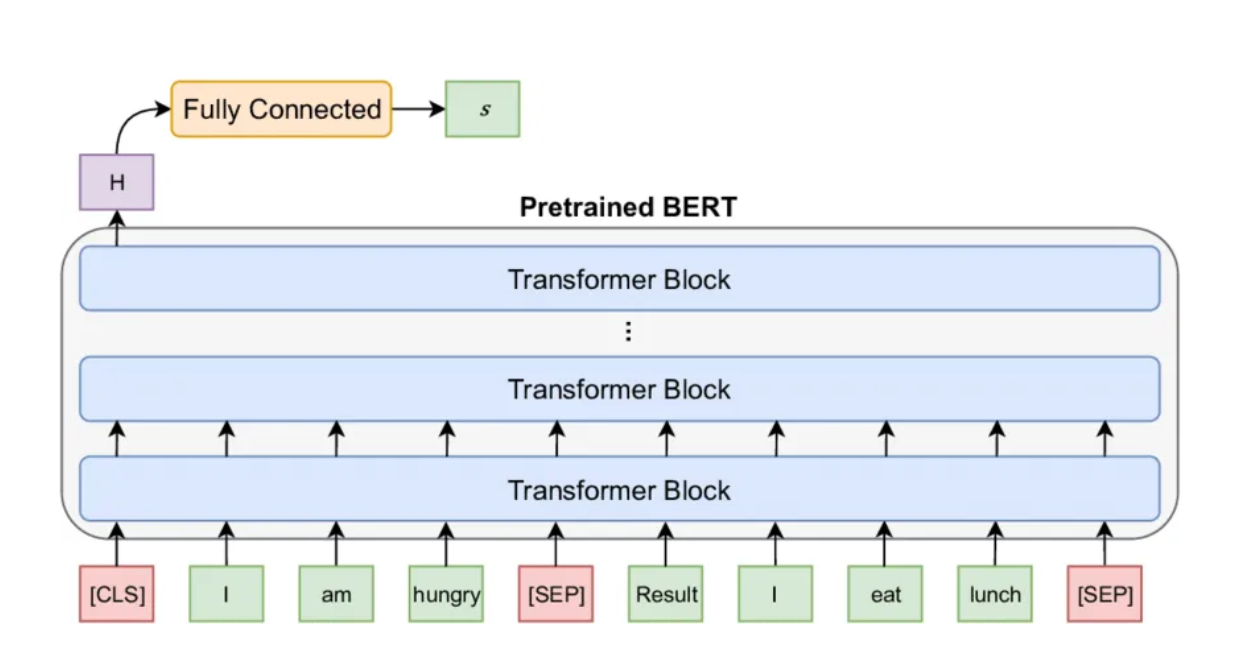
- https://medium.com/@pyroswolf200/fine-tuning-bert-on-imdb-review-dataset-309e90b6dac0

The IMDb Movie Reviews dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. In this article we will try to classify film review sentences as good or bad.

#### Without all the model, just loading from HG

In [2]:
#ShoW each Cell's Execution Time
# !pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-07-15 09:16:40 +03:00)


In [3]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print(f" DEVICE: {DEVICE}. GPU: {torch.cuda.get_device_name(0)} is available.")    
else:
    DEVICE = 'cpu'
    print(f" DEVICE: {DEVICE}. No GPU available. Training will run on CPU."  )    

 DEVICE: cuda:0. GPU: NVIDIA GeForce RTX 4050 Laptop GPU is available.
time: 3.5 s (started: 2024-07-15 09:16:41 +03:00)


In [248]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import  BertTokenizer, BertModel ,get_linear_schedule_with_warmup #,BertForSequenceClassification, AutoTokenizer 
from datasets import load_dataset
from torch.utils.data import Subset

import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re
import os 


time: 0 ns (started: 2024-07-15 13:58:07 +03:00)


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")

time: 0 ns (started: 2024-07-15 09:16:47 +03:00)


In [6]:
import sys
sys.path.append('./src') #link to GTL libraries
import src.guided_transfer_learning as gtl

time: 16 ms (started: 2024-07-15 09:16:47 +03:00)


#### Functions:

In [7]:
# Iterate over all parameters in the model
def check_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} is || TRAINABLE || ")
        else:
            print(f"{name} is || NOT TRAINABLE || ")

def count_trainable_layers(model):
    trainable_layers = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_layers += 1
    return trainable_layers

def count_parameters(model): 
    print("Number of parameters:", sum(p.numel() for p in model.parameters()))

def unfreeze_BERT_layers(bert, nb_layer_to_unfreeze):
    
    if (0 < nb_layer_to_unfreeze <= len(bert.encoder.layer)):
        # Unfreeze the last 'nb_layer_to_unfreeze' layers
        for layer in bert.encoder.layer[-nb_layer_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True
        # Freeze the remaining layers
        for layer in bert.encoder.layer[:len(bert.encoder.layer) - nb_layer_to_unfreeze]:
            for param in layer.parameters():
                param.requires_grad = False
    else:
        print(" Number of unfreeze layers is larger than number of layers or less than 1.")
     


def change_label(i, labels):
    labels.sort()

def change_dataset_labels(dataset, new_classes):
    for i in range(len(dataset.labels)):
        dataset.labels[i] = change_label(dataset.labels[i],new_classes)
        
# Define the plotting function
def plot_loss(numbers): 
    plt.figure(figsize=(8, 5)) 
    plt.plot(range(1, len(numbers) + 1), numbers, marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss (Epochs)')
    plt.grid(True)
    plt.show()

def plot_acc_loss(results):
    # Create a figure and axis objects for the loss and accuracy plots
    fig, axs = plt.subplots(1,2, figsize=(16, 4))

    # Plot the loss values
    axs[0].plot(results[0], label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    # Plot the accuracy values
    axs[1].plot(results[1], label='Accuracy', color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training Accuracy')

    # Show the plots
    plt.show()

def plot_results(results, title='Training and Validation Loss'):
    # Unpack the results
    train_loss, train_acc = results['train_resutls']
    val_loss, val_acc = results['validatoin_results']

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the training and validation accuracy
    axs[0].plot(train_acc, label='Training Accuracy')
    axs[0].plot(val_acc, label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # Plot the training and validation loss
    axs[1].plot(train_loss, label='Training Loss')
    axs[1].plot(val_loss, label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(title)
    axs[1].legend()

    # Show the plot
    plt.show()

time: 0 ns (started: 2024-07-15 09:16:47 +03:00)


In [8]:
# Define the training function
def train_model(model, optimizer, criterion, epochs, train_loader, validation_loader, train_loader_sampler=None, validation_loader_sampler=None, verbose=True, with_GTL=False, guidance_matrix=None, patience=3):
    """ If the training or validation loaders have samplers, must pass the samplers to the function"""
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    skip = 5000 if epochs > 10000 else 500 if epochs > 1000 else 20 if epochs > 100 else 2 if epochs > 10 else 1
    model.train() # Set the model to training mode
    train_loss_vals = []; train_acc_vals = []; val_loss_vals = []; val_acc_vals = [];

    # scheduler adjusts the learning rate for each batch during training
    num_training_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    #For each epoch
    for epoch in range(epochs):
        epoch_loss = 0.0;epoch_loss_sum = 0.0; epoch_acc = 0; epoch_acc_sum = 0.0; 
        print(f"Epoch: {epoch+1} \nTraining: ", end= '') 

        #Batch training       
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            model.zero_grad() # Ensure all gradients are zero
            loss.backward() # Computes dloss/dx for every parameter x which has requires_grad=True and saves it in x.grad

            if with_GTL and guidance_matrix is None:
                print('Guidance matrix is not provided')
                return None
            if with_GTL and guidance_matrix is not None:# Multiply the gradient of each parameter in the model with the corresponding value in the guidance matrix.
                gtl.apply_guidance(model, guidance_matrix) 

            optimizer.step()  # Optimizer.step updates the value of x using the gradient x.grad
            scheduler.step() # Adjusts the learning rate according to the scheduler's strategy

            predictions = torch.argmax(outputs, dim=1) 
            epoch_loss_sum += loss.item()
            epoch_acc_sum += (predictions == labels).sum().item()

        #Calculate accuracy and loss  
        epoch_loss = epoch_loss_sum / len(train_loader) 
        epoch_acc = epoch_acc_sum / len(train_loader_sampler) if train_loader_sampler else epoch_acc_sum/len(train_loader.dataset) 
        train_loss_vals.append(epoch_loss)
        train_acc_vals.append(epoch_acc) 
        
        val_loss, val_acc = evaluate_model(model, validation_loader, criterion, validation_loader_sampler)
        val_loss_vals.append(val_loss)
        val_acc_vals.append(val_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == patience:
                print(f'Early stopping after {epochs_without_improvement+1} epochs without improvement.')
                print(f'- Training loss: {epoch_loss:.2f} - Training acc: {epoch_acc:.2f} - Validation loss: {val_loss:.2f} - Validation acc: {val_acc:.2f}\n - lr: {optimizer.param_groups[0]["lr"]}')
                break

        time.sleep(12)
        if verbose and ((epoch + 1) % skip == 0 or epoch == 0 or epoch == epochs - 1):
            print(f'- Training loss: {epoch_loss:.2f} - Training acc: {epoch_acc:.2f} - Validation loss: {val_loss:.2f} - Validation acc: {val_acc:.2f}\n - lr: {optimizer.param_groups[0]["lr"]}')

    return {'train_resutls':[train_loss_vals, train_acc_vals], 'validatoin_results': [val_loss_vals,val_acc_vals],}


# Define the evaluation function
def evaluate_model(model, loader, criterion, loader_sampler=None, versbose=False):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0;total_acc = 0 ;
    print("Evaluating: ", end= '')
    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device=DEVICE)
            attention_mask = batch['attention_mask'].to(device=DEVICE)
            labels = batch['labels'].to(device=DEVICE)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()
    avg_loss = total_loss / len(loader)
    accuracy = total_acc / len(loader_sampler) if loader_sampler else total_acc/len(loader.dataset)
    if versbose:
        print(f'Test loss: {avg_loss:.2f} Test acc: {accuracy:.2f}') 
    return avg_loss, accuracy

time: 0 ns (started: 2024-07-15 09:16:47 +03:00)


In [9]:
# Define custom model architecture
class ClassificationBERT(nn.Module):
    """
    will create a classification model built on BERT with all BERT layers frozen 
    """
    def __init__(self, bert,num_labels,dropout=0.1):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert.config.hidden_size, num_labels) 
        
        # #freeze embedding first layers
        # self.bert.embeddings.word_embeddings.weight.requires_grad = False
        # self.bert.embeddings.position_embeddings.weight.requires_grad = False
        # self.bert.embeddings.token_type_embeddings.weight.requires_grad = False
        # self.bert.embeddings.LayerNorm.weight.requires_grad = False
        # self.bert.embeddings.LayerNorm.bias.requires_grad = False

        # #all BERT layers frozen by default
        # for layer in self.bert.encoder.layer[:]:
        #     for param in layer.parameters():
        #         param.requires_grad = False

        # Freeze BERT embedding layers (word embeddings, position embeddings, layer norm layers)
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        # Freeze BERT encoder layers
        for layer in self.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

time: 0 ns (started: 2024-07-15 09:16:47 +03:00)


In [10]:
# Initialize model, criterion, and optimizer
num_labels = 10
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ClassificationBERT_model = ClassificationBERT(bert, num_labels) 
ClassificationBERT_model.to(DEVICE) 

ClassificationBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

time: 5.7 s (started: 2024-07-15 09:16:47 +03:00)


#### Goemotions Dataset:

- download dataset

In [11]:
#load the dataset from hugging face datasets
goemotions_dataset = load_dataset('go_emotions') 

time: 16.2 s (started: 2024-07-15 09:16:53 +03:00)


In [12]:
# explore dataset: Dataset Dictonary of 3 datasets
goemotions_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

time: 0 ns (started: 2024-07-15 09:17:09 +03:00)


In [13]:
#dataset labels: 
goemotions_label_to_id = {
    'admiration': 0,
    'amusement': 1,
    'anger': 2,
    'annoyance': 3,
    'approval': 4,
    'caring': 5,
    'confusion': 6,
    'curiosity': 7,
    'desire': 8,
    'disappointment': 9,
    'disapproval': 10,
    'disgust': 11,
    'embarrassment': 12,
    'excitement': 13,
    'fear': 14,
    'gratitude': 15,
    'grief': 16,
    'joy': 17,
    'love': 18,
    'nervousness': 19,
    'optimism': 20,
    'pride': 21,
    'realization': 22,
    'relief': 23,
    'remorse': 24,
    'sadness': 25,
    'surprise': 26,
    'neutral': 27
}

time: 0 ns (started: 2024-07-15 09:17:09 +03:00)


- Only take only data points that have one label:

In [57]:
goemotions_train_dataset = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1)
goemotions_val_dataset = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) ==1 ) 
goemotions_test_dataset = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1) 

time: 15 ms (started: 2024-07-15 09:36:55 +03:00)


In [58]:
print(len(goemotions_dataset['train'])); print(len(goemotions_train_dataset ) );
print('_____________________________________')
print(len( goemotions_dataset['validation'])); print(len(goemotions_val_dataset) ) ;
print('_____________________________________')
print(len( goemotions_dataset['test'])); print(len(goemotions_test_dataset) ) ;
print('_____________________________________')

43410
36308
_____________________________________
5426
4548
_____________________________________
5427
4590
_____________________________________
time: 0 ns (started: 2024-07-15 09:36:57 +03:00)


- Random Data ponts from Goemotions dataset:

In [59]:
for i in random.sample(range(0,43000), 8):
    print(goemotions_dataset['train'].__getitem__(i))

{'text': "There's no reason ever to get [NAME] breakfast tacos when you live in Austin.", 'labels': [27], 'id': 'ef2ebkq'}
{'text': 'Here, we [NAME] are open books. Brutal, and often hilarious truth in every word we speak 😂', 'labels': [1, 3], 'id': 'edf3aob'}
{'text': 'I guess you could say that it was unexpected', 'labels': [27], 'id': 'ef8eyly'}
{'text': "I was actually thinking about that during tonight's episode. I don't think the show would last long without [NAME] though.", 'labels': [22], 'id': 'eeo40ko'}
{'text': 'Wow must be a good market. Could maybe hit up to $150 a day', 'labels': [0], 'id': 'ef7lf0f'}
{'text': 'For the [NAME] I always love our deep ACC Tourney runs. I’d love a regular season championship though', 'labels': [18], 'id': 'eefxb6v'}
{'text': "redemption island? I'm not judging if you like it just curious", 'labels': [7], 'id': 'ef0027p'}
{'text': "Um....Yes? I would love it if everyone didn't believe in [NAME].", 'labels': [7], 'id': 'eeumqwe'}
time: 0 ns (st

- Define a preprocessing function to tokenize the text and encode it as input ids and attention masks  


In [60]:
def goemotions_preprocess_function(examples):
    # inputs = tokenizer(examples['text'], truncation=True, padding='max_length', return_tensors='pt')
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64, add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    new_labels =  [example[0] for example in examples['labels']]  
    return {'input_ids': inputs['input_ids'].squeeze(), 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': torch.tensor(new_labels)}

time: 0 ns (started: 2024-07-15 09:37:01 +03:00)


- Convert datasets to torch Dataset


In [61]:
class CustomDatasetClass(Dataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.labels = dataset['labels']

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels':torch.tensor(self.labels[idx], dtype=torch.long)
            }
    def __len__(self):
        return len(self.input_ids) 

time: 0 ns (started: 2024-07-15 09:37:01 +03:00)


- Preprocess the train and test datasets

In [62]:
goemotions_train_dataset = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1)
goemotions_val_dataset = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) ==1 ) 
goemotions_test_dataset = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1)

goemotions_train_dataset = goemotions_train_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_val_dataset = goemotions_val_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_test_dataset = goemotions_test_dataset.map(goemotions_preprocess_function, batched=True) 

goemotions_train_dataset = CustomDatasetClass(goemotions_train_dataset)
goemotions_val_dataset = CustomDatasetClass(goemotions_val_dataset)
goemotions_test_dataset = CustomDatasetClass(goemotions_test_dataset)

time: 2.2 s (started: 2024-07-15 09:37:02 +03:00)


#### Testing the Convergence of the model (28 classes):
If the model does not converge, the calculation of the Guidance matrix will not make sense.


- Train only classifier with all layers frozen

In [112]:
# To add: Exploratory Data Analysis of goemotions_train_dataset

time: 16 ms (started: 2024-07-08 16:33:00 +03:00)


In [21]:
num_labels = 28  # number of labels in the datasetclass_indices = list(range(28))
criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation
# criterion = nn.BCEWithLogitsLoss()
batch_size = 128  # batch size for data loader

time: 0 ns (started: 2024-07-13 08:04:51 +03:00)


In [22]:
train_num_samples = 30000 # samples to train, taken randomly from training set
val_num_samples = 4000 # samples to test, taken randomly from test set 
test_num_samples =  4000

train_random_sampler = RandomSampler(goemotions_train_dataset, num_samples=train_num_samples) 
val_random_sampler = RandomSampler(goemotions_val_dataset, num_samples=val_num_samples)
test_random_sampler = RandomSampler(goemotions_test_dataset, num_samples=test_num_samples)

goemotions_train_loader = DataLoader(goemotions_train_dataset, batch_size=batch_size, sampler=train_random_sampler)
goemotions_val_loader = DataLoader(goemotions_val_dataset, batch_size=batch_size, sampler=val_random_sampler)
goemotions_test_loader = DataLoader(goemotions_test_dataset,  batch_size=batch_size,sampler=test_random_sampler)

time: 0 ns (started: 2024-07-13 08:04:53 +03:00)


- Train Classifier with BERT frozen (Unfreeze One layer):

In [23]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:14<00:00,  3.15it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


- Training loss: 2.57 - Training acc: 0.35 - Validation loss: 2.34 - Validation acc: 0.39
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 2.24 - Training acc: 0.40 - Validation loss: 2.13 - Validation acc: 0.42
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


- Training loss: 2.10 - Training acc: 0.43 - Validation loss: 2.07 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 2.04 - Training acc: 0.43 - Validation loss: 2.02 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 15s (started: 2024-07-13 08:04:56 +03:00)


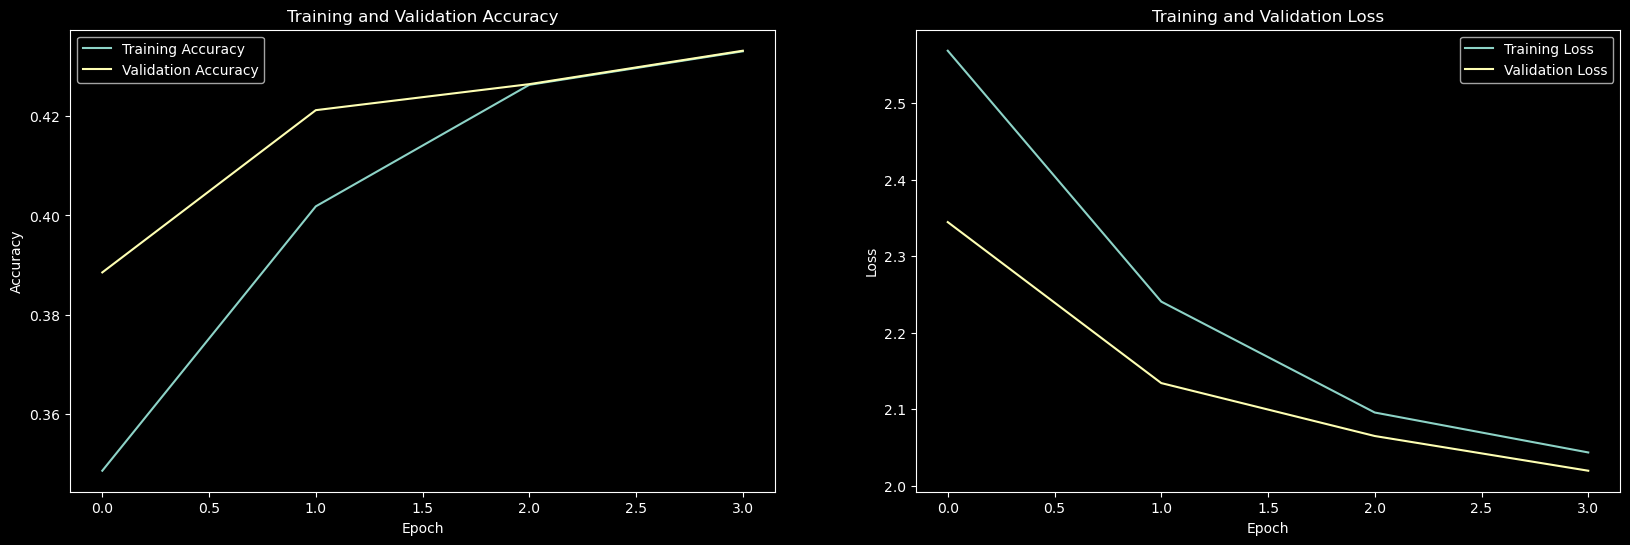

time: 204 ms (started: 2024-07-13 08:16:07 +03:00)


In [24]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [25]:
nb_of_layers_to_unfreeze = 1  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 1 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.87it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 2.00 - Training acc: 0.44 - Validation loss: 1.84 - Validation acc: 0.47
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.77 - Training acc: 0.49 - Validation loss: 1.71 - Validation acc: 0.51
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.91it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


- Training loss: 1.54 - Training acc: 0.55 - Validation loss: 1.54 - Validation acc: 0.55
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.89it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


- Training loss: 1.43 - Training acc: 0.58 - Validation loss: 1.46 - Validation acc: 0.57
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.93it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 1.36 - Training acc: 0.60 - Validation loss: 1.41 - Validation acc: 0.58
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.91it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch: 10 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.87it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 1.31 - Training acc: 0.61 - Validation loss: 1.39 - Validation acc: 0.58
 - lr: 5e-06
Epoch: 11 
Training: 

100%|██████████| 235/235 [01:22<00:00,  2.86it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.29 - Training acc: 0.62 - Validation loss: 1.39 - Validation acc: 0.58
 - lr: 4.5e-06
- BERT Fine-tuning finished.

time: 18min 30s (started: 2024-07-13 08:16:15 +03:00)


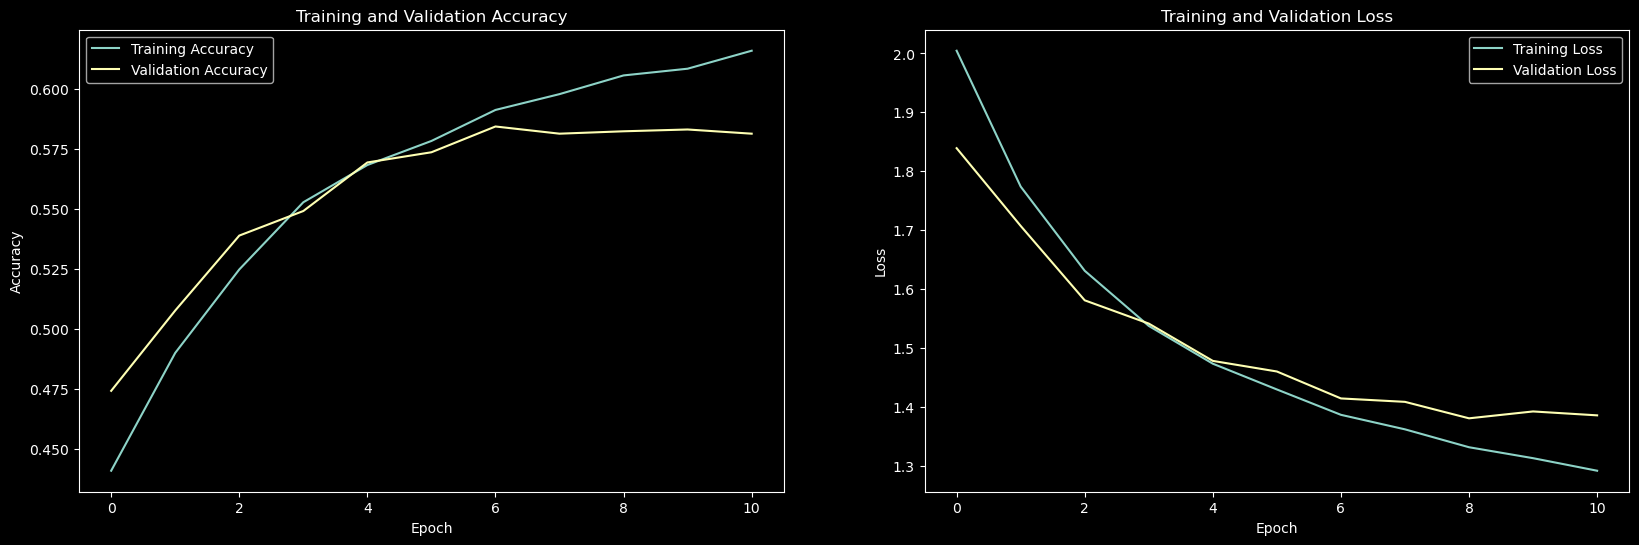

time: 157 ms (started: 2024-07-13 08:34:45 +03:00)


In [26]:
plot_results(goemotions_train_losses_fine_tune) 

In [28]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

Test loss: 1.39 Test acc: 0.60
time: 9.74 s (started: 2024-07-13 08:41:03 +03:00)


- The dataset of texts we have for classification using BERT is inherently limited in its ability to achieve an accuracy of more than 60%. This is due to the nature of the data and the complexity of the problem being addressed (28 classes).

- Train Classifier with BERT frozen (Unfreeze two layers):

In [29]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:12<00:00,  3.25it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


- Training loss: 2.55 - Training acc: 0.35 - Validation loss: 2.33 - Validation acc: 0.39
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:10<00:00,  3.33it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 2.23 - Training acc: 0.40 - Validation loss: 2.15 - Validation acc: 0.42
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 2.09 - Training acc: 0.43 - Validation loss: 2.05 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


- Training loss: 2.04 - Training acc: 0.43 - Validation loss: 2.03 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 13s (started: 2024-07-13 08:46:12 +03:00)


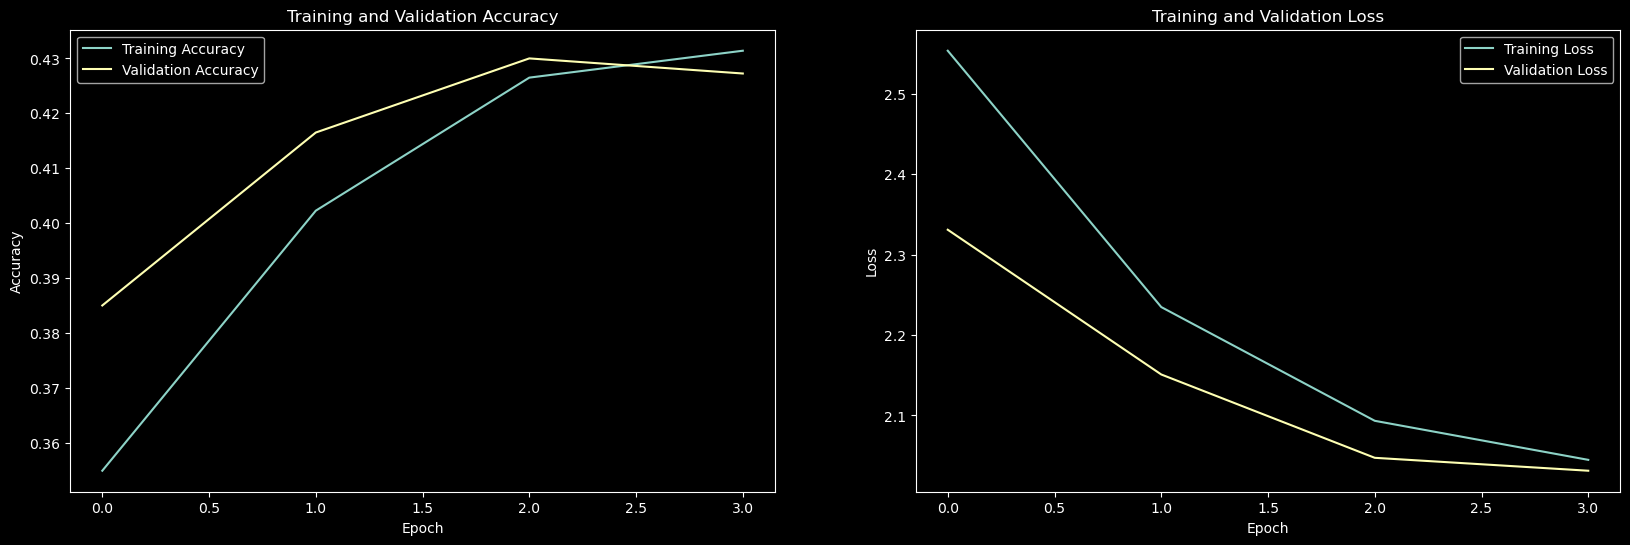

time: 282 ms (started: 2024-07-13 08:52:25 +03:00)


In [30]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [31]:
nb_of_layers_to_unfreeze = 2  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 2 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:34<00:00,  2.49it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


- Training loss: 1.93 - Training acc: 0.46 - Validation loss: 1.70 - Validation acc: 0.51
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 1.61 - Training acc: 0.53 - Validation loss: 1.54 - Validation acc: 0.56
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.58it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 1.39 - Training acc: 0.59 - Validation loss: 1.44 - Validation acc: 0.58
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.28 - Training acc: 0.62 - Validation loss: 1.38 - Validation acc: 0.59
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.21 - Training acc: 0.64 - Validation loss: 1.35 - Validation acc: 0.59
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:32<00:00,  2.54it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.18 - Training acc: 0.65 - Validation loss: 1.34 - Validation acc: 0.60
 - lr: 5.500000000000001e-06
- BERT Fine-tuning finished.

time: 16min 44s (started: 2024-07-13 08:52:25 +03:00)


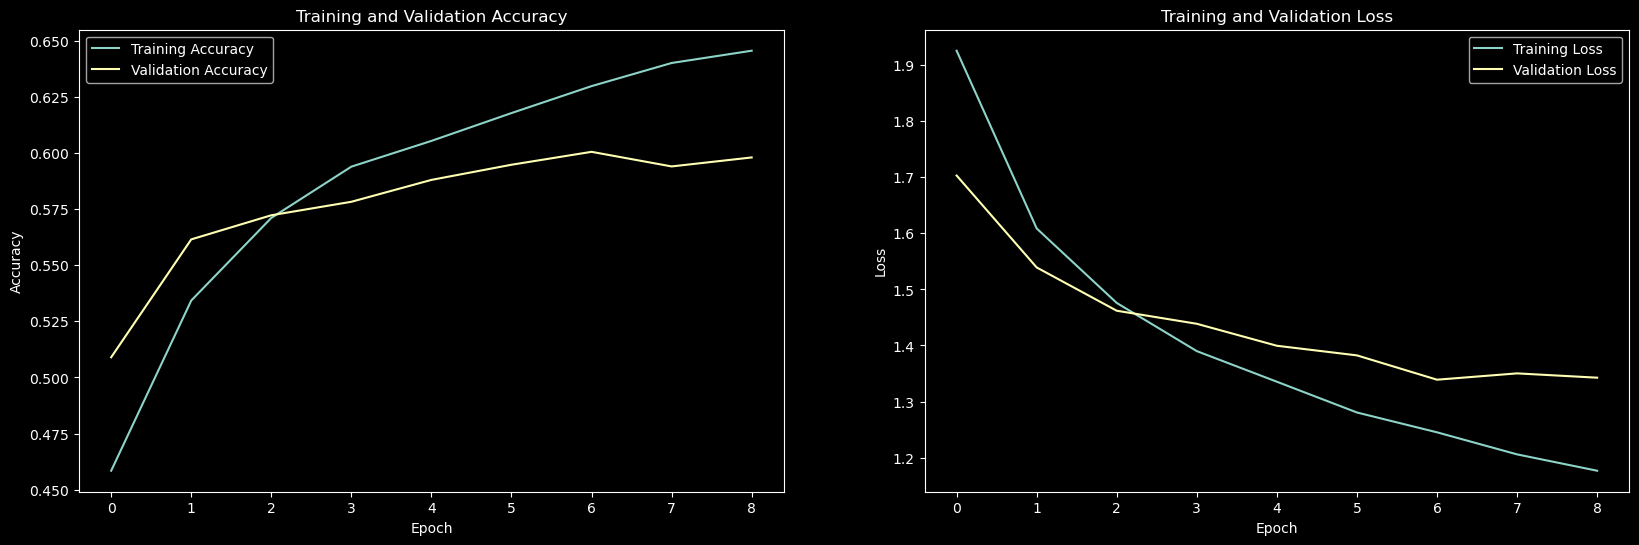

time: 156 ms (started: 2024-07-13 09:09:10 +03:00)


In [32]:
plot_results(goemotions_train_losses_fine_tune) 

In [33]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:10<00:00,  3.00it/s]

Test loss: 1.33 Test acc: 0.61
time: 10.7 s (started: 2024-07-13 09:09:10 +03:00)


- Train Classifier with BERT frozen (Unfreeze three layers):

In [34]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:13<00:00,  3.22it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


- Training loss: 2.58 - Training acc: 0.35 - Validation loss: 2.34 - Validation acc: 0.38
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 2.24 - Training acc: 0.40 - Validation loss: 2.15 - Validation acc: 0.41
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


- Training loss: 2.10 - Training acc: 0.43 - Validation loss: 2.05 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.28it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 2.05 - Training acc: 0.43 - Validation loss: 2.03 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 13s (started: 2024-07-13 09:26:23 +03:00)


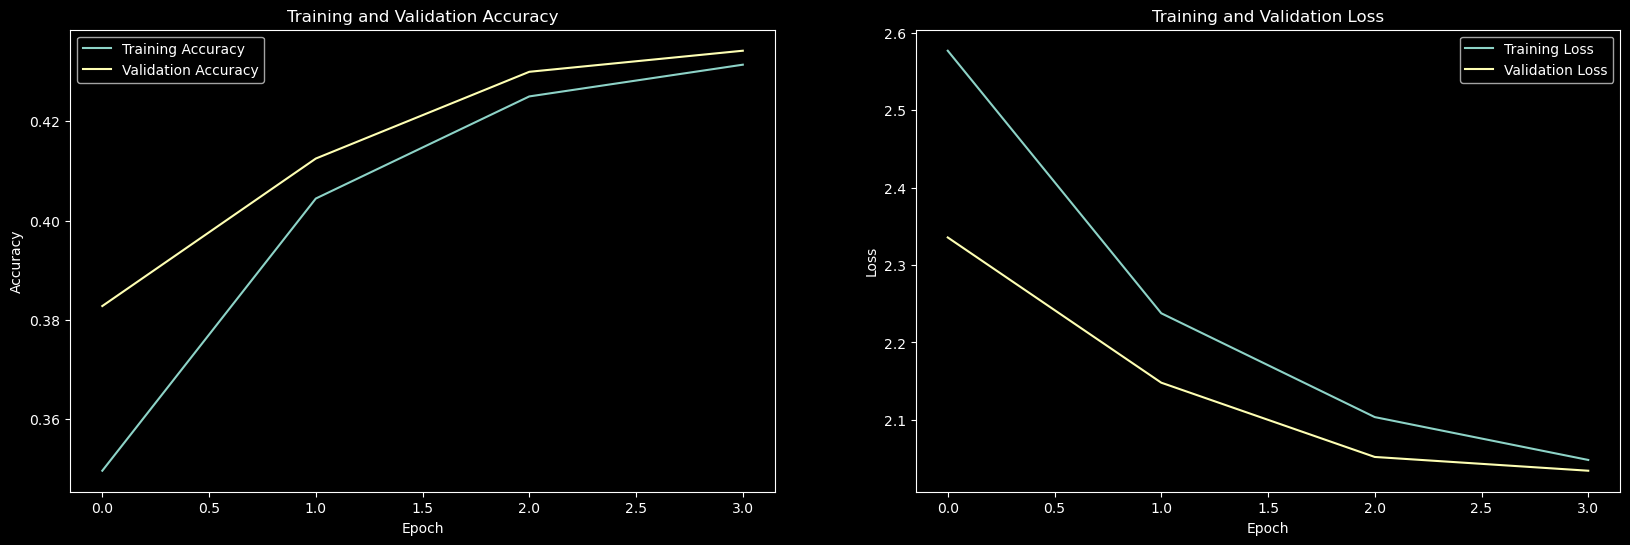

time: 250 ms (started: 2024-07-13 09:32:37 +03:00)


In [35]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [36]:
nb_of_layers_to_unfreeze = 3  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 3 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:45<00:00,  2.23it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


- Training loss: 1.85 - Training acc: 0.48 - Validation loss: 1.63 - Validation acc: 0.52
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 1.52 - Training acc: 0.55 - Validation loss: 1.46 - Validation acc: 0.57
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


- Training loss: 1.32 - Training acc: 0.61 - Validation loss: 1.36 - Validation acc: 0.60
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


- Training loss: 1.19 - Training acc: 0.64 - Validation loss: 1.33 - Validation acc: 0.60
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


- Training loss: 1.10 - Training acc: 0.67 - Validation loss: 1.30 - Validation acc: 0.60
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 10 
Training: 

100%|██████████| 235/235 [01:47<00:00,  2.19it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.02 - Training acc: 0.69 - Validation loss: 1.35 - Validation acc: 0.60
 - lr: 5e-06
- BERT Fine-tuning finished.

time: 20min 42s (started: 2024-07-13 09:32:37 +03:00)


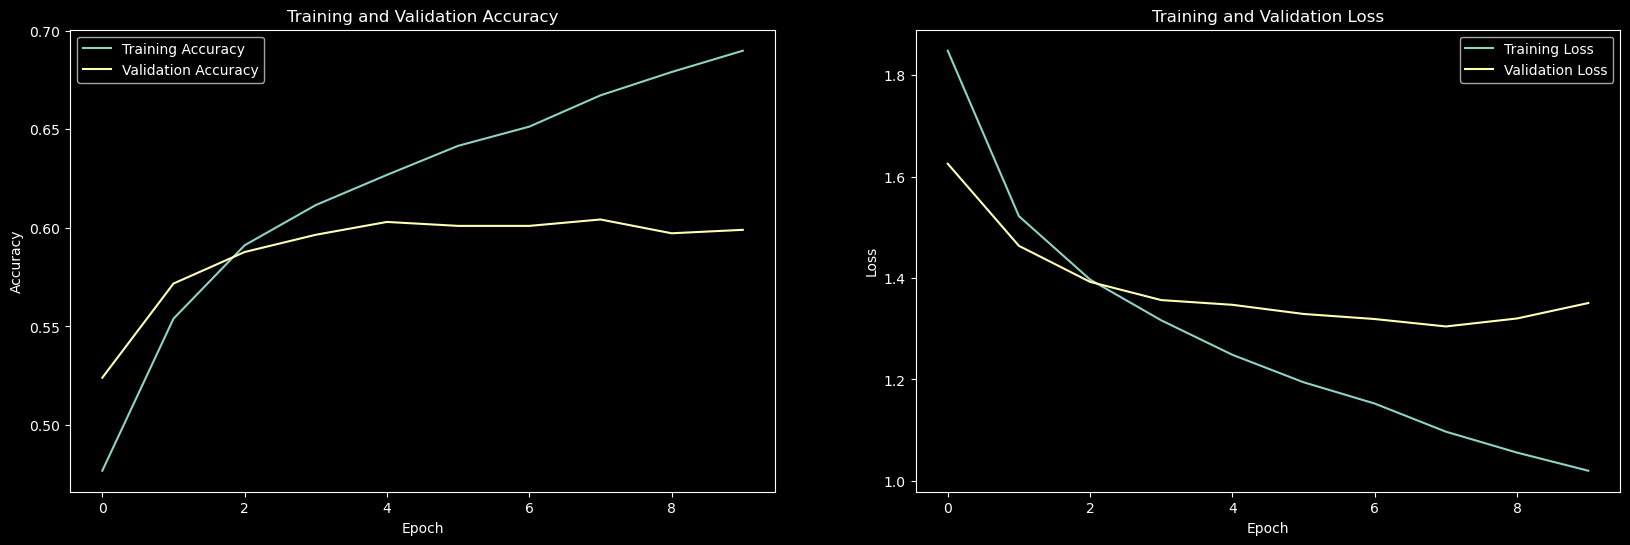

time: 219 ms (started: 2024-07-13 09:53:20 +03:00)


In [37]:
plot_results(goemotions_train_losses_fine_tune) 

In [38]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:10<00:00,  2.96it/s]

Test loss: 1.33 Test acc: 0.61
time: 10.8 s (started: 2024-07-13 09:53:21 +03:00)


In [40]:
count_parameters(ClassificationBERT_)

Number of parameters: 109503772
time: 0 ns (started: 2024-07-13 10:18:17 +03:00)


#### Scouts & Guidance matrix::

Things to be done:

1) We start from a pre-trained model, M. We unfreeze all the parameters.

2) Next, we split the data set into two separate data sets, one with 18 classes (dataset A) and the other with the remaining 10 classes (dataset B).

3) We then create 10 scouts out of dataset A only. We make sure that each scout has only 10 classes randomly picked from the 18 classes of dataset A. Each scout is trained as transfer learning starting from model M.

4) Next, we create the guiding matrix using the parameters of M and of the ten scouts.

5) After that, we use dataset B only as our downstream task. In this task, we start again with model M.

6) (a) We train the model with the 10 classes of dataset B using the guidance matrix. For this training, we use only a single example -- one-shot learning. The rest of the data are used for testing.

6) (b) We do the same as in 6a but without using the guidance matrix.

7) We compare the results obtained in 6a and 6b.


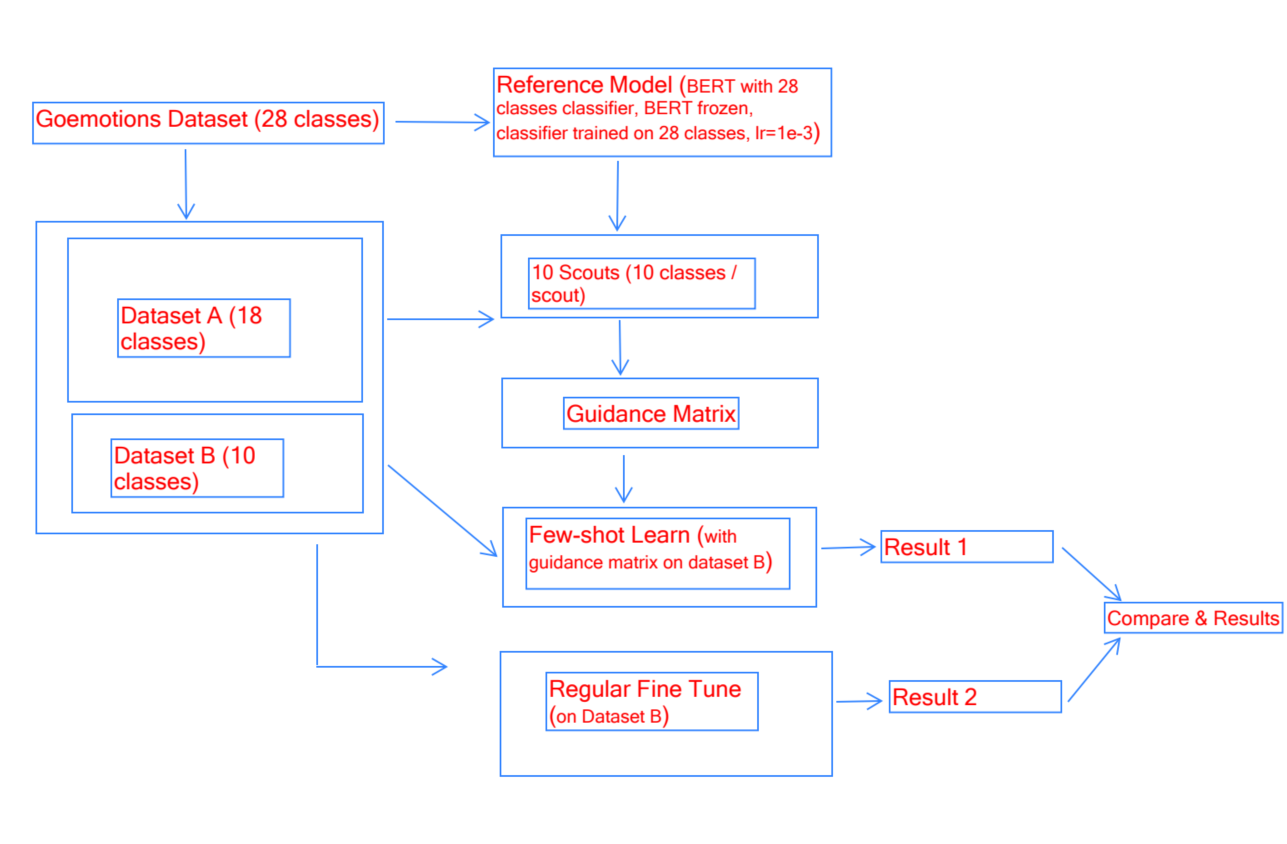

- Create Reference Model: classifier should not be trained at all 

In [364]:
num_labels = 10  # number of labels in the datasetclass_indices = list(range(28))

bert_reference = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_reference = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)
print("- Classifier training with BERT frozen is finished.\n")
nb_of_layers_to_unfreeze = 1  # number of layers to unfreeze in the BERT model
unfreeze_BERT_layers(bert_reference, nb_of_layers_to_unfreeze)
my_scouts = gtl.create_scouts(ClassificationBERT_reference, should_save_guidance=True, should_save_scouts=False, use_squared_differences=True)
print("Scouts created")

- BERT downloaded.
- Classifier training with BERT frozen is finished.

Scouts created
time: 1.23 s (started: 2024-07-15 15:26:44 +03:00)


In [ ]:
# take 8 labels for downstream task
# train on the the remaining 20 

# 5 scouts each with 8 labels. scout_indexes, 
# scout_indexes = [[0,1,2,3,4,5,6,7], [8,9,10,11,12,13,14,15] , [16,17,18,19,0,1,2,3], [etc.]]  

- Spliting dataset into 2 Datasets A & B:

In [ ]:
goemotions_train_dataset = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1)
goemotions_val_dataset = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) ==1 ) 
goemotions_test_dataset = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1)

goemotions_train_dataset = goemotions_train_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_val_dataset = goemotions_val_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_test_dataset = goemotions_test_dataset.map(goemotions_preprocess_function, batched=True) 

goemotions_train_dataset = CustomDatasetClass(goemotions_train_dataset)
goemotions_val_dataset = CustomDatasetClass(goemotions_val_dataset)
goemotions_test_dataset = CustomDatasetClass(goemotions_test_dataset)

In [335]:
nb_scouts = 10  # number of scouts to create
batch_size = 16  # batch size for data loader
lr_fine_tuning = 5e-5
epochs_fine_tuning = 8  

time: 0 ns (started: 2024-07-15 15:10:36 +03:00)


In [336]:
# choose random classes for datasets A and B: A 18 classes and B 10 classes
random_classes_A = random.sample(range(0,27), 18)                       ;random.shuffle(random_classes_A);
random_classes_B = [i for i in range(28) if i not in random_classes_A]  ;random.shuffle(random_classes_B);

print('random classes A: ', random_classes_A)
print('random classes B: ', random_classes_B)

random classes A:  [21, 5, 16, 24, 20, 25, 1, 11, 22, 15, 14, 13, 9, 23, 0, 12, 19, 18]
random classes B:  [26, 4, 27, 10, 2, 8, 17, 7, 6, 3]
time: 0 ns (started: 2024-07-15 15:10:36 +03:00)


In [ ]:
batch_size = 128

# Create train indexes for new Datasets A and B
train_indexes_A = [i for i, item in enumerate(goemotions_train_dataset) if item['labels'] in random_classes_A]
train_indexes_B = [i for i, item in enumerate(goemotions_train_dataset) if item['labels'] in random_classes_B]

# Create val indexes for new Datasets A and B
val_indexes_A = [i for i, item in enumerate(goemotions_val_dataset) if item['labels'] in random_classes_A]
val_indexes_B = [i for i, item in enumerate(goemotions_val_dataset) if item['labels'] in random_classes_B]

# Create train subsets from the indexes 
goemotions_train_subset_A = Subset(goemotions_train_dataset, train_indexes_A) 
goemotions_train_subset_B = Subset(goemotions_train_dataset, train_indexes_B) 

# Create val subsets from the indexes 
goemotions_val_subset_A = Subset(goemotions_val_dataset, val_indexes_A)
goemotions_val_subset_B = Subset(goemotions_val_dataset, val_indexes_B)

# Create train data loaders from subsets
goemotions_subset_train_loader_A = DataLoader(goemotions_train_subset_A, batch_size=batch_size, shuffle=True)
goemotions_subset_train_loader_B = DataLoader(goemotions_train_subset_B, batch_size=batch_size, shuffle=True)

# Create validation data loaders from subsets
goemotions_subset_val_loader_A = DataLoader(goemotions_val_subset_A, batch_size=batch_size, shuffle=True)
goemotions_subset_val_loader_B = DataLoader(goemotions_val_subset_B, batch_size=batch_size, shuffle=True)


In [ ]:
print('========================')
print('len(train_random_samples_A): ', len(train_indexes_A) )
print('len(train_random_samples_B): ', len(train_indexes_B) )
print('Sum: ', len(train_indexes_A) + len(train_indexes_B))
print('========================')
print('len(val_random_samples_A): ', len(val_indexes_A) )
print('len(val_random_samples_A): ', len(val_indexes_B) )
print('Sum: ',len(val_indexes_A) + len(val_indexes_B))
print('========================') 

len(train_random_samples_A):  17561
len(train_random_samples_B):  18747
Sum:  36308
len(val_random_samples_A):  2194
len(val_random_samples_A):  2354
Sum:  4548
time: 0 ns (started: 2024-07-15 09:52:32 +03:00)


In [338]:
#check if datasets have common indexes:
def has_common_elements(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return len(set1.intersection(set2)) > 0

print(has_common_elements(train_indexes_A, train_indexes_B))
print(has_common_elements(val_indexes_A, val_indexes_B))

False
False
time: 15 ms (started: 2024-07-15 15:10:38 +03:00)


In [355]:
# choose random classes for datasets A and B: A 18 classes and B 10 classes
random_classes_A = random.sample(range(0,27), 18)                       ;random.shuffle(random_classes_A);
random_classes_B = [i for i in range(28) if i not in random_classes_A]  ;random.shuffle(random_classes_B);

print('random classes A: ', random_classes_A)
print('random classes B: ', random_classes_B)

random classes A:  [3, 9, 1, 21, 10, 2, 22, 11, 18, 12, 17, 13, 15, 0, 24, 14, 7, 16]
random classes B:  [6, 27, 8, 20, 25, 5, 23, 26, 19, 4]
time: 0 ns (started: 2024-07-15 15:15:21 +03:00)


In [358]:
# Take 10 random classes from the 18 classes in dataset A for the scout:
ten_random_classes = random.sample(random_classes_A, 10) 
ten_random_classes_np = np.array(ten_random_classes)
ten_random_classes_np = ten_random_classes_np.reshape(len(ten_random_classes_np), 1)

ten_classes_train_indexes = [i for i,item in enumerate(goemotions_train_subset_A) if item['labels'] in ten_random_classes]  
ten_classes_val_indexes = [i for i,item in enumerate(goemotions_val_subset_A) if item['labels'] in ten_random_classes] 
ten_random_classes.sort()
print(ten_random_classes)

goemotions_train_dataset_ten_classes = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np) 
goemotions_val_dataset_ten_classes = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np)

goemotions_train_dataset_ten_classes = goemotions_train_dataset_ten_classes.map(goemotions_preprocess_function, batched=True)
goemotions_val_dataset_ten_classes = goemotions_val_dataset_ten_classes.map(goemotions_preprocess_function, batched=True) 

goemotions_train_dataset_ten_classes  = CustomDatasetClass(goemotions_train_dataset_ten_classes)
goemotions_val_dataset_ten_classes  = CustomDatasetClass(goemotions_val_dataset_ten_classes)

goemotions_train_loader_ten_classes = DataLoader(goemotions_train_dataset_ten_classes, batch_size=16,shuffle=True)
goemotions_val_loader_ten_classes = DataLoader(goemotions_val_dataset_ten_classes, batch_size=16, shuffle=True)

change_dataset_labels(goemotions_train_dataset_ten_classes, ten_random_classes)
change_dataset_labels(goemotions_val_dataset_ten_classes, ten_random_classes)



[1, 3, 9, 11, 13, 16, 17, 21, 22, 24]


Map: 100%|██████████| 811/811 [00:00<00:00, 4710.05 examples/s]


time: 2.31 s (started: 2024-07-15 15:22:19 +03:00)


In [360]:
for batch in goemotions_train_loader_ten_classes:
    print(batch)
    break

{'input_ids': tensor([[ 101, 5667, 1029,  ...,    0,    0,    0],
        [ 101, 9616, 1029,  ...,    0,    0,    0],
        [ 101, 8840, 2140,  ...,    0,    0,    0],
        ...,
        [ 101, 8840, 2140,  ...,    0,    0,    0],
        [ 101, 5292, 3270,  ...,    0,    0,    0],
        [ 101, 2043, 2111,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([3, 3, 0, 9, 3, 0, 6, 1, 8, 2, 0, 0, 0, 0, 0, 1])}
time: 16 ms (started: 2024-07-15 15:22:48 +03:00)


In [361]:
for batch in goemotions_val_loader_ten_classes:
    print(batch)
    break

{'input_ids': tensor([[  101,  1031,  2171,  ...,     0,     0,     0],
        [  101,  2859, 16844,  ...,     0,     0,     0],
        [  101,  1998,  2002,  ...,     0,     0,     0],
        ...,
        [  101,  6289,  2092,  ...,     0,     0,     0],
        [  101,  2821,  1010,  ...,     0,     0,     0],
        [  101,  6289,  2026,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 8, 0, 8, 0, 8, 0, 8, 0, 4, 6, 4, 3, 8, 2, 9])}
time: 0 ns (started: 2024-07-15 15:22:58 +03:00)


In [367]:
# choose random classes for datasets A and B: A 18 classes and B 10 classes
random_classes_A = random.sample(range(0,27), 18)                       ;random.shuffle(random_classes_A);
random_classes_B = [i for i in range(28) if i not in random_classes_A]  ;random.shuffle(random_classes_B);

print('random classes A: ', random_classes_A)
print('random classes B: ', random_classes_B)


nb_scouts = 1
lr_fine_tuning = 2e-5
epochs = 1
patience  = 3 
batch_size = 128 
loss_function = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

for i in range(nb_scouts):
    print(f"=============================================================\nScout nb {i+1}/{nb_scouts} Training Start:")  
    ##############################################################################################################################
    
    # Take 10 random classes from the 18 classes in dataset A for the scout:
    print("Choosing 10 random classes from dataset A")
    ten_random_classes = random.sample(random_classes_A, 10) 
    ten_random_classes_np = np.array(ten_random_classes)
    ten_random_classes_np = ten_random_classes_np.reshape(len(ten_random_classes_np), 1)

    ten_classes_train_indexes = [i for i,item in enumerate(goemotions_train_subset_A) if item['labels'] in ten_random_classes]  
    ten_classes_val_indexes = [i for i,item in enumerate(goemotions_val_subset_A) if item['labels'] in ten_random_classes] 
    ten_random_classes.sort()
    print("Random Classes: ", ten_random_classes)

    #choosing the data points that have one label and the label is in the 10 random classes chosen from the 18 classes (Dataset A)
    print("Filtering Dataset for selected labels:")
    goemotions_train_dataset_ten_classes = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np) 
    goemotions_val_dataset_ten_classes = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np)

    print("Len(Training Dataset) : ", len(goemotions_train_dataset_ten_classes))
    print("Len(Validation Dataset) : ", len(goemotions_val_dataset_ten_classes))
    
    #preparing the dataset with the pre processing fn
    print("Pre processing dataset")
    goemotions_train_dataset_ten_classes = goemotions_train_dataset_ten_classes.map(goemotions_preprocess_function, batched=True)
    goemotions_val_dataset_ten_classes = goemotions_val_dataset_ten_classes.map(goemotions_preprocess_function, batched=True) 

    # using CustomDatasetClass to make a dataset with input_ids, attention_mask, and labels
    goemotions_train_dataset_ten_classes  = CustomDatasetClass(goemotions_train_dataset_ten_classes)
    goemotions_val_dataset_ten_classes  = CustomDatasetClass(goemotions_val_dataset_ten_classes)

    #preparing the data loader from the ten classes dataset
    goemotions_train_loader_ten_classes = DataLoader(goemotions_train_dataset_ten_classes, batch_size=batch_size,shuffle=True)
    goemotions_val_loader_ten_classes = DataLoader(goemotions_val_dataset_ten_classes, batch_size=batch_size, shuffle=True)

    #Changing the labels to be in [0,...,9] 
    change_dataset_labels(goemotions_train_dataset_ten_classes, ten_random_classes)
    change_dataset_labels(goemotions_val_dataset_ten_classes, ten_random_classes)
    
    # Create BERT  model and load weights from reference model:
    bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
    print("- BERT downloaded.")
    ClassificationBERT_scout = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)
    unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
    ClassificationBERT_scout.load_state_dict(ClassificationBERT_reference.state_dict())    
    print(f"- Starting training model with {nb_of_layers_to_unfreeze} layer(s) unfrozen.") 
   
   # train model (not intersted in results: _)
    _ = train_model(ClassificationBERT_scout,
                    AdamW(ClassificationBERT_scout.parameters(),lr=lr_fine_tuning),
                    loss_function,
                    epochs=epochs,
                    train_loader=goemotions_train_loader_ten_classes,
                    validation_loader=goemotions_val_loader_ten_classes,
                    verbose=True,
                    patience=patience) 
    print("- Fine-tuning of BERT is finished.") 
    print(f"Scout nb {i+1}/{nb_scouts} Training End.\n=============================================================\n") 
    my_scouts.add_scout(ClassificationBERT_scout) 

random classes A:  [10, 19, 7, 9, 20, 4, 17, 24, 14, 26, 15, 23, 11, 22, 5, 8, 12, 6]
random classes B:  [13, 1, 3, 21, 16, 25, 0, 27, 18, 2]
Scout nb 1/1 Training Start:
Choosing 10 random classes from dataset A
Random Classes:  [4, 5, 6, 9, 14, 19, 20, 22, 24, 26]
Filtering Dataset for selected labels:


Filter: 100%|██████████| 5426/5426 [00:00<00:00, 81592.88 examples/s]


Len(Training Dataset) :  7124
Len(Validation Dataset) :  941
Pre processing dataset


Map: 100%|██████████| 941/941 [00:00<00:00, 4570.30 examples/s]


- BERT downloaded.
- Starting training model with 1 layers unfrozen.
Epoch: 1 
Training: 

100%|██████████| 56/56 [00:19<00:00,  2.88it/s]


Evaluating: 

100%|██████████| 8/8 [00:02<00:00,  3.66it/s]


- Training loss: 2.22 - Training acc: 0.22 - Validation loss: 2.12 - Validation acc: 0.27
 - lr: 0.0
- Fine-tuning of BERT is finished.
Scout nb 1/1 Training End.

time: 37.5 s (started: 2024-07-15 15:38:27 +03:00)


# Here

In [67]:
# Train scouts for guidance matrix, (Testing for 1 scout, 1 epoch): 
num_labels = 10 
nb_scouts = 1
lr_fine_tuning = 2e-5
epochs = 1
patience  = 3 
batch_size = 128 
criterion = nn.CrossEntropyLoss() 

for i in range(nb_scouts):
    print(f"=============================================================\nScout nb {i+1}/{nb_scouts} Training Start:")  
    ##############################################################################################################################
    
    # Take 10 random classes from the 18 classes in dataset A for the scout:
    random_classes = random.sample(random_classes_A, 10) 
    train_indexes = [i for i,item in enumerate(goemotions_train_subset_A) if item['labels'] in random_classes] 
    val_indexes = [i for i,item in enumerate(goemotions_val_subset_A) if item['labels'] in random_classes]
    print(random_classes)
    
    # Creating a subset from the 10 classes for scout:
    goemotions_train_subset = Subset(goemotions_train_subset_A, train_indexes)
    goemotions_val_subset = Subset(goemotions_val_subset_A, val_indexes)

    # Change labels of the dataset to [0,1,2,...,9] 


    
    # creating loaders for the subset: 
    goemotions_subset_train_loader = DataLoader(goemotions_train_subset,batch_size=batch_size,shuffle=True)
    goemotions_subset_val_loader = DataLoader(goemotions_val_subset, batch_size=batch_size,shuffle=True)
    
    # Create BERT  model and load weights from reference model:
    bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
    print("- BERT downloaded.")
    ClassificationBERT_scout = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)
    unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
    ClassificationBERT_scout.load_state_dict(ClassificationBERT_reference.state_dict())    
    print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.") 
   
   # train model (not intersted in results: _)

   # change 
    # _ = train_model(ClassificationBERT_scout,
    #                 AdamW(ClassificationBERT_scout.parameters(),lr=lr_fine_tuning),
    #                 criterion,
    #                 epochs=epochs,
    #                 train_loader=goemotions_subset_train_loader,
    #                 validation_loader=goemotions_subset_val_loader,
    #                 verbose=True,
    #                 patience=patience) 
    print("- Fine-tuning of BERT is finished.") 
    print(f"Scout nb {i+1}/{nb_scouts} Training End.\n=============================================================\n") 
    # my_scouts.add_scout(ClassificationBERT_scout) 

Scout nb 1/1 Training Start:
[4, 7, 13, 25, 6, 19, 8, 14, 10, 26]
- BERT downloaded.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


time: 1.08 s (started: 2024-07-14 13:39:43 +03:00)


In [61]:
labels = [4,7,11,25,24,23,5,19,18,1]

time: 0 ns (started: 2024-07-14 13:37:02 +03:00)


time: 0 ns (started: 2024-07-14 13:37:03 +03:00)


In [60]:
#create the guidance matrix from the scouts:

raw_guidance_matrix = my_scouts.create_raw_guidance(DEVICE)
# print(raw_guidance_matrix)
# print(gtl.get_guidance_values(raw_guidance_matrix))

time: 453 ms (started: 2024-07-12 09:52:09 +03:00)


#### Plot Guidance Matrix:

- Plot Classifier from Guidance Matrix:

In [ ]:
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.weight')
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.bias') 

- Plot all BERT Layers from Guidance Matrix:

In [32]:
encoder_sub_layers_list = ['attention.self.query.weight',
'attention.self.query.bias' ,
'attention.self.key.weight',
 'attention.self.key.bias' ,
 'attention.self.value.weight',  
 'attention.self.value.bias' ,
 'attention.output.dense.weight',  
 'attention.output.dense.bias' ,
 'attention.output.LayerNorm.weight',  
 'attention.output.LayerNorm.bias'  ,
 'intermediate.dense.weight'  ,
 'intermediate.dense.bias'  ,
 'output.dense.weight'  ,
 'output.dense.bias'  ,
 'output.LayerNorm.weight',  
 'output.LayerNorm.bias',  ]

time: 0 ns (started: 2024-07-12 08:25:06 +03:00)


- Plots

In [ ]:
for layer_num in range(12-nb_of_layers_to_unfreeze,12):
    for sub_layer in encoder_sub_layers_list:
        gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
        print(f'bert.encoder.layer.{layer_num}.{sub_layer}')

# for layer_num in range(0,12):
#     for sub_layer in encoder_sub_layers_list:
#         gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
#         # print(f'bert.encoder.layer.{layer_num}.{sub_layer}')


In [31]:
# del raw_guidance_matrix

time: 0 ns (started: 2024-07-08 19:07:29 +03:00)


#### Train with & without Guidance Matrix on Dataset B

In [36]:
print(len(goemotions_train_subset_B))
print(len(goemotions_val_subset_B))

22370
2832
time: 0 ns (started: 2024-07-12 08:29:49 +03:00)


In [65]:
len(train_indexes_B)

22370

time: 0 ns (started: 2024-07-12 10:15:18 +03:00)


In [78]:
random_classes_B

[20, 9, 26, 15, 1, 27, 17, 14, 21, 25]

time: 0 ns (started: 2024-07-12 10:23:07 +03:00)


- Training with Guidance Matrix (Few-Shot learn):

In [73]:
# !!!!!
# To add:  should take 10 examples form each class, data points should not be added randomly
# !!!!! 
# 

total_random_indexes = []
for class_ in random_classes_B:
    limit = 10
    #get 10 random data points from goemotions_train_subset_B
    class_indexes = []
    for i,item in enumerate(goemotions_train_subset_B):
        if item['labels'] == class_:
            class_indexes.append(i)
            if len(class_indexes) == limit:
                total_random_indexes.extend(class_indexes)
                break
print(len(total_random_indexes))
print(total_random_indexes)

100
[23, 92, 121, 171, 177, 197, 226, 271, 274, 296, 48, 65, 73, 77, 107, 143, 151, 153, 216, 225, 3, 67, 98, 116, 152, 183, 189, 199, 211, 270, 4, 8, 14, 21, 33, 58, 69, 78, 81, 99, 6, 37, 44, 79, 80, 114, 133, 138, 144, 145, 0, 1, 5, 7, 9, 10, 11, 12, 13, 15, 17, 61, 96, 101, 108, 125, 129, 163, 167, 201, 2, 84, 90, 160, 191, 206, 207, 221, 227, 517, 168, 973, 2235, 3464, 3773, 4071, 4539, 5573, 6040, 6056, 19, 45, 47, 118, 119, 135, 139, 176, 223, 304]
time: 110 ms (started: 2024-07-12 10:21:55 +03:00)


In [76]:
goemotions_train_subset_B.__getitem__(92)

{'input_ids': tensor([ 101, 2204, 6735, 8937,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(20)}

time: 0 ns (started: 2024-07-12 10:22:34 +03:00)


In [80]:
goemotions_train_subset_A_10pointsFromCLass = Subset(goemotions_train_dataset, total_random_indexes)
goemotions_fewshot_subset_train_loader_B = DataLoader(goemotions_train_subset_A_10pointsFromCLass, batch_size=16, shuffle=True)

for bat

time: 0 ns (started: 2024-07-12 10:28:28 +03:00)


In [ ]:
# prepare some random data points from the dataset B:
DatasetB_train_indexes = [i for i,item in enumerate(goemotions_train_subset_B)]

# !!!!!
# To add:  should take 10 examples form each class, data points should not be added randomly
# !!!!! 

#labels of subset goemotions_train_subset_B = random_classes_B 


#indexes, subset and train loader to  train model with guidance matrix on the random data points::
random_train_indexes = random.sample(DatasetB_train_indexes, 100)
goemotions_fewshot_subset_B = Subset(goemotions_train_subset_B, random_train_indexes)
goemotions_fewshot_subset_train_loader_B = DataLoader(goemotions_fewshot_subset_B, batch_size=16, shuffle=True)

In [39]:
ClassificationBERT_reference_path = 'C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'

time: 0 ns (started: 2024-07-12 08:31:45 +03:00)


In [42]:
# len(goemotions_train_subset_B)

time: 0 ns (started: 2024-07-12 08:32:08 +03:00)


In [44]:
# Load refrence model:
 
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)
# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)     
# load weights from a reference model so that models start from the reference model:
ClassificationBERT_.load_state_dict(torch.load(ClassificationBERT_reference_path)) 

<All keys matched successfully>

time: 344 ms (started: 2024-07-12 08:32:28 +03:00)


In [ ]:
# should be few shot learning not fine tuning   

In [45]:
# _ = train_model(model=g_model, x=base_train_X2, y=base_train_Y2, epochs=299, guidance_matrix=guidance_matrix, lr = 0.01)
criterion = nn.CrossEntropyLoss() 
epochs = 1 
patience = 3 

#train with few shot examples from dataset B 
_ = train_model(ClassificationBERT_,
                optimizer = AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                criterion=criterion,
                epochs= epochs,
                train_loader=goemotions_fewshot_subset_train_loader_B, 
                validation_loader=goemotions_subset_val_loader_B, 
                with_GTL=True, 
                guidance_matrix=raw_guidance_matrix,
                patience=patience,
                verbose=True)

Epoch: 1 
Training: 

100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Evaluating: 

100%|██████████| 177/177 [00:08<00:00, 22.08it/s]


- Training loss: 1.74 - Training acc: 0.63 - Validation loss: 1.41 - Validation acc: 0.63

time: 22 s (started: 2024-07-12 08:32:59 +03:00)


In [47]:
# evaluate: 
eval_resutls = evaluate_model(ClassificationBERT_, 
                              criterion=criterion, 
                              loader=goemotions_fewshot_subset_train_loader_B,
                              versbose=True)

Evaluating: 

100%|██████████| 7/7 [00:00<00:00, 12.29it/s]


Test loss: 1.44 Test acc: 0.63
time: 578 ms (started: 2024-07-12 08:36:04 +03:00)


- Training with Dataset B without Guidance matrix:

In [48]:
len(goemotions_subset_train_loader_B)

1399

time: 0 ns (started: 2024-07-12 08:36:24 +03:00)


In [49]:
len(goemotions_train_subset_B)

22370

time: 0 ns (started: 2024-07-12 08:36:25 +03:00)


In [50]:
# from regex import A
nb_of_layers_to_unfreeze =   
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)  

# load weights from a reference model so that models start from the reference model:
ClassificationBERT_.load_state_dict(torch.load(ClassificationBERT_reference_path))   

epochs = 1 
patience = 3 

goemotions_train_resutls_B = train_model(ClassificationBERT_,
                                         optimizer = AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                         criterion=criterion,
                                         epochs= epochs,
                                         train_loader=goemotions_subset_train_loader_B, 
                                         validation_loader=goemotions_subset_val_loader_B, 
                                         with_GTL=False, 
                                         patience=patience,
                                         verbose=True)

Epoch: 1 
Training: 

100%|██████████| 1399/1399 [03:19<00:00,  7.00it/s]


Evaluating: 

100%|██████████| 177/177 [00:06<00:00, 27.02it/s]


- Training loss: 0.65 - Training acc: 0.81 - Validation loss: 0.54 - Validation acc: 0.83

time: 3min 38s (started: 2024-07-12 08:49:38 +03:00)


#### Compare results:
